Packages

In [2]:
import os
import numpy
import pandas as pd
import tqdm
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
import sys
sys.path.append('../scripts/')
from read_utils import read_file, create_folder, temp_record_query, temp_record_sdf

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = (
    # Create a spark session (which will run spark jobs)
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config('spark.executor.memory','10g')
    .config('spark.driver.memory','12g')
    .config('spark.driver.maxResultsSize', '10GiB')
    # .config("spark.network.timeout", "3600s")
    # .master("local[6]")
    .getOrCreate()
    )

22/09/26 21:49:39 WARN Utils: Your hostname, Runyus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.12 instead (on interface en0)
22/09/26 21:49:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 21:49:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/26 21:49:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
file_name_list = sorted(os.listdir('../data/curated/data'))

In [4]:
sdf = read_file(spark, 'data', '../data/curated/')

|> Loading File...


|> Loading Finished!
-RECORD 0-----------------------------------------------
 user_id         | 1                                    
 merchant_abn    | 46451548968                          
 dollar_value    | 72.61581642788431                    
 order_id        | 76bab304-fa2d-4004-8179-8638b56a873e 
 merchant_name   | Tempus Eu Ligula Limited             
 tags            | health and beauty spas               
 take_rate       | 6.04                                 
 type            | a                                    
 consumer_id     | 1195503                              
 name            | Yolanda Williams                     
 address         | 413 Haney Gardens Apt. 742           
 state           | WA                                   
 postcode        | 6935                                 
 gender          | Female                               
 New cases / day | 1,621                                
 order_datetime  | 2021-11-26                           
only showi

In [5]:
# type
type_indexer = StringIndexer(inputCol = "type", outputCol = "typeIndex", handleInvalid="skip")

# gender
gender_indexer = StringIndexer(inputCol = "gender", outputCol = "genderIndex", handleInvalid="skip")

# tag
tag_indexer = StringIndexer(inputCol = "tags",outputCol = "tagIndex", handleInvalid="skip")
onehotencoder_tag_vector = OneHotEncoder(inputCol = "tagIndex", outputCol = "tag_vec")

#Create pipeline and pass all stages
pipeline = Pipeline(stages=[gender_indexer, 
                            type_indexer,
                            tag_indexer,
                            onehotencoder_tag_vector])

In [6]:
sdf.show(5)

+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+-----------+-----------------+--------------------+-----+--------+------+---------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|       merchant_name|                tags|take_rate|type|consumer_id|             name|             address|state|postcode|gender|New cases / day|order_datetime|
+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+-----------+-----------------+--------------------+-----+--------+------+---------------+--------------+
|      1| 46451548968| 72.61581642788431|76bab304-fa2d-400...|Tempus Eu Ligula ...|health and beauty...|     6.04|   a|    1195503| Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|          1,621|    2021-11-26|
|      1| 49167531725| 51.58228625503599|7080c274-17f7-4cc...|     Felis Institute|digital goods: bo...|

In [7]:
sdf_transformed = pipeline.fit(sdf).transform(sdf)
sdf_transformed.show(5)

+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+-----------+-----------------+--------------------+-----+--------+------+---------------+--------------+-----------+---------+--------+---------------+
|user_id|merchant_abn|      dollar_value|            order_id|       merchant_name|                tags|take_rate|type|consumer_id|             name|             address|state|postcode|gender|New cases / day|order_datetime|genderIndex|typeIndex|tagIndex|        tag_vec|
+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+-----------+-----------------+--------------------+-----+--------+------+---------------+--------------+-----------+---------+--------+---------------+
|      1| 46451548968| 72.61581642788431|76bab304-fa2d-400...|Tempus Eu Ligula ...|health and beauty...|     6.04|   a|    1195503| Yolanda Williams|413 Haney Gardens...|   WA|    6935|Fe

- figure out that tag_vec

In [8]:
SAMPLE_SIZE = 0.05
sdf_transformed = sdf_transformed.sample(SAMPLE_SIZE, seed=0)

In [9]:
df_transformed = sdf_transformed.toPandas()
df_transformed

,user_id,merchant_abn,dollar_value,order_id,merchant_name,tags,take_rate,type,consumer_id,name,address,state,postcode,gender,New cases / day,order_datetime,genderIndex,typeIndex,tagIndex,tag_vec
0,17,18709053174,22.392280,901d96f0-5400-47b8-9b84-f4e662aa4ce8,Massa Rutrum Industries,tent and awning shops,3.39,b,1331093,Alyssa Wilson,44353 Nathan Ridge,VIC,3719,Female,"1,621",2021-11-26,1.0,1.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,52,73499119023,16.299283,5f4af1eb-e9aa-437e-850d-e50694a1eff3,Nisi Dictum Company,"watch, clock, and jewelry repair shops",5.56,a,95154,Wendy Brown,27343 Rodriguez Ports,WA,6963,Female,"1,621",2021-11-26,1.0,0.0,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,170,78982081666,106.189382,056852ba-612a-4dc3-a9f3-53a02ff2d888,Lectus Corp.,"books, periodicals, and newspapers",4.96,b,1430320,Nicole Russo,661 Moore Island,WA,6313,Female,"1,621",2021-11-26,1.0,1.0,12.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,226,94547309480,142.604001,6df86507-6255-4610-a6aa-88474c6c9d93,Lorem Ac Institute,bicycle shops - sales and service,2.66,c,710483,Emily Singh,0107 Flores Street Suite 423,SA,5642,Female,"1,621",2021-11-26,1.0,2.0,18.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,250,78327477486,517.366887,45feae7d-f31f-41f3-8b97-73c24ce779c8,Auctor Inc.,"lawn and garden supply outlets, including nurs...",1.47,c,470403,Robert Ochoa,326 Hodges Square,VIC,3447,Male,"1,621",2021-11-26,0.0,2.0,13.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216722,17961,76767266140,342.948509,7bf22352-e342-4e01-83a0-81ce45219027,Phasellus At Limited,"furniture, home furnishings and equipment shop...",4.65,b,1008461,Rebecca Morse,2629 Debra Parks,SA,5276,Female,"33,079",2022-01-26,1.0,1.0,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
216723,18639,17488304283,76.787254,397cb2b2-c1f5-4a9f-b22d-3a2d31091bda,Posuere Cubilia Curae Corporation,"cable, satellite, and other pay television and...",6.18,a,994231,Mallory Allen,374 Thomas Vista,NSW,4375,Female,"33,079",2022-01-26,1.0,0.0,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
216724,19189,80324045558,74.506476,a4af9ede-695a-4479-ad98-bc23979eb236,Ipsum Dolor Sit Corporation,"gift, card, novelty, and souvenir shops",1.47,c,1102313,Brandy Robinson,3149 Mary Junction Apt. 899,WA,6923,Female,"33,079",2022-01-26,1.0,2.0,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
216725,21171,89726005175,45.786481,ec7d731c-c3d9-47f5-8313-fab3d392840a,Est Nunc Consulting,tent and awning shops,6.01,a,562461,Mark Hughes,28321 Davis Groves Apt. 024,WA,6517,Male,"33,079",2022-01-26,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


- postcode latitude and longitude change

According to the size of csv file, choose pandas to do the dataframe slice

In [44]:
sdf = read_file(spark, 'data', '../data/curated/')

|> Loading File...
|> Loading Finished!
-RECORD 0-----------------------------------------------
 user_id         | 1                                    
 merchant_abn    | 46451548968                          
 dollar_value    | 72.61581642788431                    
 order_id        | 76bab304-fa2d-4004-8179-8638b56a873e 
 merchant_name   | Tempus Eu Ligula Limited             
 tags            | health and beauty spas               
 take_rate       | 6.04                                 
 type            | a                                    
 consumer_id     | 1195503                              
 name            | Yolanda Williams                     
 address         | 413 Haney Gardens Apt. 742           
 state           | WA                                   
 postcode        | 6935                                 
 gender          | Female                               
 New cases / day | 1,621                                
 order_datetime  | 2021-11-26                   

In [45]:
postcode_spark = read_file(spark, '../curated/sa2_pos_geometry.csv', type='csv')

|> Loading File...
|> Loading Finished!
22/09/26 22:04:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , postcode, place_name, state_name, state_code, latitude, longitude, accuracy, SA2_CODE21, geometry, centroid
 Schema: _c0, postcode, place_name, state_name, state_code, latitude, longitude, accuracy, SA2_CODE21, geometry, centroid
Expected: _c0 but found: 
CSV file: file:///Users/runyuyang/Downloads/2022S2/generic-buy-now-pay-later-project-group-24/data/curated/sa2_pos_geometry.csv
-RECORD 0--------------------------------------------------------------------------------------
 _c0        | 0                                                                                
 postcode   | 200                                                                              
 place_name | Australian National University                                                   
 state_name | Australian Capital Territory                                                     
 

In [46]:
postcode_spark = (postcode_spark.withColumnRenamed('postcode','pos')).drop('_c0','place_name', 'state_name', 'accuracy')

In [47]:
postcode_spark.show()

+----+----------+--------+---------+----------+--------------------+--------------------+
| pos|state_code|latitude|longitude|SA2_CODE21|            geometry|            centroid|
+----+----------+--------+---------+----------+--------------------+--------------------+
| 200|       ACT|-35.2777| 149.1189| 801051049|POLYGON ((149.110...|(-35.281339155480...|
| 221|       ACT|-35.3049| 149.1412| 801061129|POLYGON ((149.129...|(-35.309254259625...|
|2540|       ACT|-35.1627| 150.6907| 901031003|MULTIPOLYGON (((1...|(-35.152358580811...|
|2600|       ACT|-35.3126| 149.1278| 801061063|POLYGON ((149.117...|(-35.317183221598...|
|2601|       ACT|-35.2813| 149.1293| 801051053|POLYGON ((149.124...|(-35.281260337413...|
|2602|       ACT|-35.2446| 149.1447| 801051061|POLYGON ((149.151...|(-35.234728334716...|
|2603|       ACT|-35.3262| 149.1191| 801061069|POLYGON ((149.116...|(-35.333447598302...|
|2604|       ACT|-35.3357| 149.1492| 801061130|POLYGON ((149.149...|(-35.321669776752...|
|2605|    

In [48]:
sdf.count()

4508106

In [49]:
sdf = sdf.join(postcode_spark, sdf.postcode == postcode_spark.pos, how = 'left')

In [50]:
sdf.count()

4508106

In [51]:
sdf.show(5)

+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+-----------+---------------+-----------------+-----+--------+------+---------------+--------------+----+----------+--------+---------+----------+--------------------+--------------------+
|user_id|merchant_abn|      dollar_value|            order_id|       merchant_name|                tags|take_rate|type|consumer_id|           name|          address|state|postcode|gender|New cases / day|order_datetime| pos|state_code|latitude|longitude|SA2_CODE21|            geometry|            centroid|
+-------+------------+------------------+--------------------+--------------------+--------------------+---------+----+-----------+---------------+-----------------+-----+--------+------+---------------+--------------+----+----------+--------+---------+----------+--------------------+--------------------+
|     18| 38090089066|121.39424925014715|b10335c0-fd77-4cd...|Interdum Feugiat 

In [52]:
sdf = sdf.drop('state_code', 'pos')

In [53]:
temp1 = sdf.dropna(how='any').count()

In [54]:
print( f'There are {sdf.count()} data, and {temp1} have no null value.')

There are 4508106 data, and 4288339 have no null value.


In [55]:
null_df = sdf.filter(sdf.longitude.isNull())

In [56]:
null_df.count()

36906

In [57]:
df1 = null_df.dropDuplicates(subset=[c for c in null_df.columns if c in ["postcode"]])

In [58]:
df1.count()

25

In [59]:
lose_df = df1.toPandas()

<AxesSubplot:xlabel='postcode', ylabel='state'>

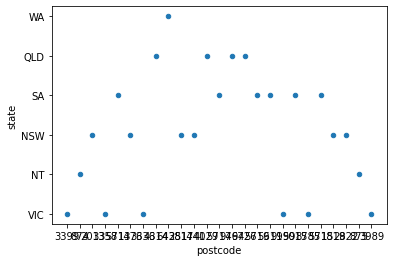

In [60]:
lose_df.plot.scatter(x='postcode', y='state')